# MNIST CNN
**Author**: Tyler Lynch<br>
**Last modified**: 25 Dec, 2024<br>
**License**: Licensed under MIT License<br>

Train: x=(60000, 28, 28), y=(60000,)
Test: x=(10000, 28, 28), y=(10000,)


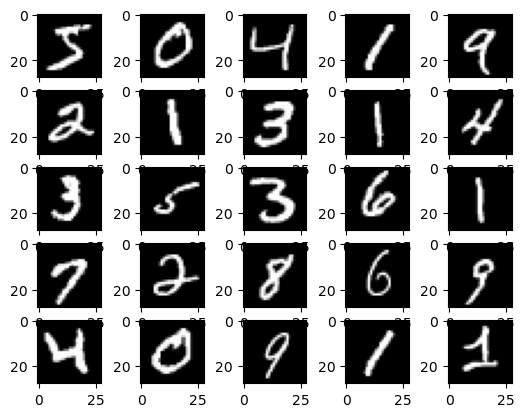

In [1]:
# Imports
from tensorflow.keras.layers import MaxPool2D, Dropout, Flatten, Conv2D, Dense
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets.mnist import load_data
from numpy import asarray, unique, argmax
from tensorflow.keras import Sequential
from matplotlib import pyplot
import pandas as pd

# Load dataset
(x_train, y_train), (x_test, y_test) = load_data()

# Summarize dataset
print('Train: x=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: x=%s, y=%s' % (x_test.shape, y_test.shape))

# Plot first 25 images
for i in range(25):
  # Define subplot
  pyplot.subplot(5, 5, i+1)
  # Plot pixel data
  pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('grey'))
# Display
pyplot.show()

In [2]:
# Reshape data to have a single channel
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

# Determine the shape of the input images
in_shape = x_train.shape[1:]

# Determine the number of classes
n_classes = len(unique(y_train))

# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [3]:
# Define model
def create_model(in_shape, n_classes):
    '''
    Create a CNN model
    :param in_shape: shape of input images
    :param n_classes: number of classes
    :return: CNN model
    '''
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=in_shape))
    model.add(MaxPool2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    
    return model

In [4]:
# Function to format the results
def format_results(results_df):
    '''
    Format the results DataFrame
    :param results_df: DataFrame containing results
    :return: formatted DataFrame
    '''
    results_df['Test Loss'] = results_df['Test Loss'].round(4)
    results_df['Test Accuracy'] = (results_df['Test Accuracy'] * 100).round(4)  # Convert to percentage
    results_df['Test Accuracy'] = results_df['Test Accuracy'].astype(str) + '%'  # Add '%' symbol
    return results_df

# Define optimizer and loss function grids
opt = ['adam', 'sgd', 'rmsprop']
loss = ['sparse_categorical_crossentropy', 'categorical_crossentropy']

# Placeholder for results
results = []

# Variables to track the best model
best_accuracy = 0
best_model = None
best_optimizer = None
best_loss_function = None

# Loop through each combination of optimizer and loss function
for optimizer in opt:
    for loss_function in loss:
        # Initialize the model (ensure it's not reused from previous iterations)
        model = create_model(in_shape=(28, 28, 1), n_classes=10)  # Adjust input shape and class count

        # One-hot encode labels if using categorical_crossentropy
        if loss_function == 'categorical_crossentropy':
            y_train_encoded = to_categorical(y_train)
            y_test_encoded = to_categorical(y_test)
        else:
            y_train_encoded = y_train
            y_test_encoded = y_test

        # Compile the model
        model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

        # Train the model
        history = model.fit(x_train, y_train_encoded, epochs=10, batch_size=32, verbose=0)

        # Evaluate the model
        test_loss, test_accuracy = model.evaluate(x_test, y_test_encoded, verbose=0)

        # Store results
        results.append({
            'Optimizer': optimizer,
            'Loss Function': loss_function,
            'Test Loss': test_loss,
            'Test Accuracy': test_accuracy
        })

        # Update the best model based on test accuracy
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = model  # Save the best model instance
            best_optimizer = optimizer
            best_loss_function = loss_function
            best_history = history

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Format the results
formatted_results = format_results(results_df)

# Print the results
print(formatted_results)

c:\Users\Lynch\anaconda3\envs\mnist\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Optimizer                    Loss Function  Test Loss Test Accuracy
0      adam  sparse_categorical_crossentropy     0.0477        98.71%
1      adam         categorical_crossentropy     0.0494        98.67%
2       sgd  sparse_categorical_crossentropy     0.0543        98.18%
3       sgd         categorical_crossentropy     0.0546        98.21%
4   rmsprop  sparse_categorical_crossentropy     0.0692        98.27%
5   rmsprop         categorical_crossentropy     0.0626        98.31%



Best Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       540,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,626,692 (6.21 MB)

 Trainable params: 542,230 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,084,462 (4.14 MB)


Best Optimizer: adam
Best Loss Function: sparse_categorical_crossentropy


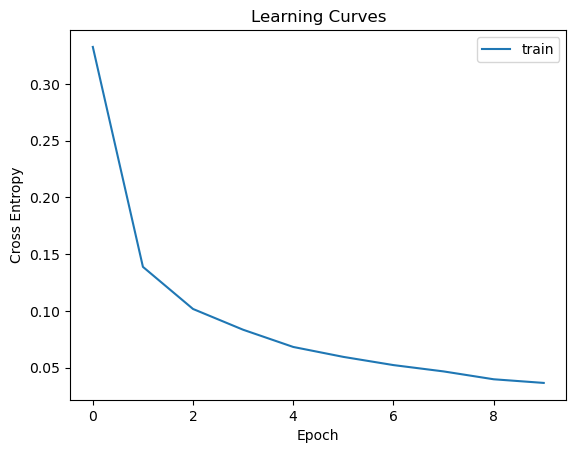

In [16]:
if best_model:
    print("\nBest Model Summary:")
    best_model.summary()

    # Print the best optimizer and loss function
    print(f"\nBest Optimizer: {best_optimizer}")
    print(f"Best Loss Function: {best_loss_function}")

    # Plot learning curves (display only)
    pyplot.title('Learning Curves')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Cross Entropy')
    pyplot.plot(best_history.history['loss'], label='train')
    if 'val_loss' in best_history.history:
        pyplot.plot(best_history.history['val_loss'], label='val')
    pyplot.legend()
    pyplot.show()

In [8]:
# Make a prediction. Change the index to test a different image.
image = x_train[0]
yhat = model.predict(asarray([image]))
print('Predicted: class=%d' % argmax(yhat))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted: class=5
